This test case will use MNIST to verify the performance of different neural encoding schemes.

Block for importing libraries

In [ ]:
import cv2
import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras import initializers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.optimizers import Adam
#because of multiclass datasets
from tensorflow.keras import utils
import random

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf

In [ ]:
def GetDataset(dataset_path):
    data = scipy.io.loadmat(dataset_path)
    raw_data = np.squeeze(data['receivedSig'])
    target = np.squeeze(data['target'])

    x_train = raw_data[:1000]
    y_train = target[:1000]
    x_test = raw_data[1000:]
    y_test = target[1000:]
    x_train = np.reshape(x_train, (len(x_train)))
    x_test = np.reshape(x_test, (len(x_test)))
    return x_train, y_train, x_test, y_test

In [ ]:
def feature_normalize(X):

    # feature_normalize: Normalizes the features in X
    # feature_normalize(X): returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.
    # This is often a good preprocessing step to do when working with learning algorithms.

    mu     = 0
    sigma  = 0
    mu     = np.mean(X)
    sigma  = np.std(X)
    X      = (X - mu) / sigma
    X_norm = X

    return X_norm

The TTFS encoder first.

In [ ]:
def TTFS_Encoder(input, tau = 20, thr = 0.2, tmax = 290.2, epsilon = 1e-7):
  idx = input < thr
  input = np.clip(input, thr + epsilon, 1e9)
  output = tau * np.log(input / (input - thr))
  output[idx] = tmax
  return output

Test the encoder with simple input.

In [ ]:
TestResult = TTFS_Encoder(np.array([[1, 2, 4, 8]]))
TestResult

array([[4.46287103, 2.10721031, 1.02586589, 0.50635616]])

Visualize the function of TTFS encoder.

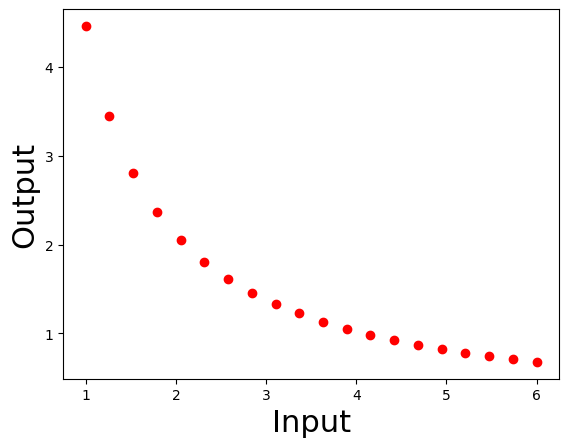

In [ ]:
input_x = np.linspace(1.0, 6.0, num=20)
plt.plot(input_x, TTFS_Encoder(np.array([input_x]))[0], 'ro')
plt.xlabel('Input', fontsize = 22)
plt.ylabel('Output', fontsize = 22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

It works well. Move to the ISI encoder.
This encoder is using the parallel structure which is easier to be implemented is circuit level and is what I have implemented in circuit.

In [ ]:
def ISI_Encoder(input, N = 3):
  output = np.zeros(N)
  for j in range(N):
    output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)
  return output

Test the ISI encoder with simple input

In [ ]:
ISITestResult = ISI_Encoder(3)
ISITestResult

/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


array([1.37985743, 1.74022754, 2.10721031])

Visualize the ISI encoder.

[[4.46287103 5.75364145 7.13349888]
 [2.75242756 3.50408178 4.28509208]
 [1.99059191 2.52081442 3.06547743]
 [1.55923083 1.96880146 2.38693515]
 [1.28157713 1.61522713 1.95453782]
 [1.08788144 1.36935599 1.65484854]
 [0.9450577  1.18846841 1.4348781 ]
 [0.83538826 1.04980365 1.26654268]
 [0.74852811 0.94012085 1.13356674]
 [0.67803103 0.85119229 1.02586589]]


/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


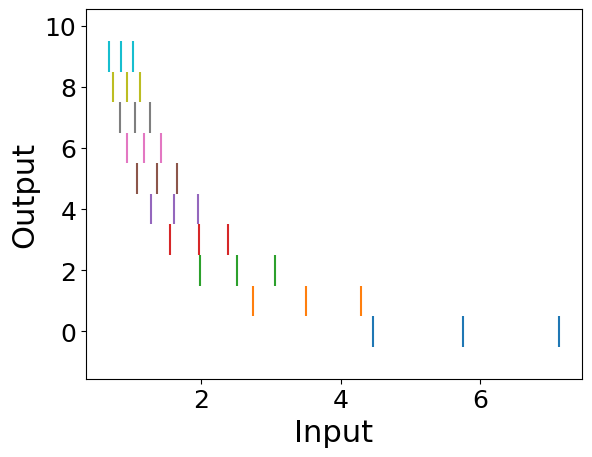

In [ ]:
input_x = np.linspace(1.0, 6.0, num=10)
ISI_spike_plot = np.zeros((10, 3))
for i in range(10):
  ISI_spike_plot[i] = ISI_Encoder(input_x[i])
print(ISI_spike_plot)
plt.eventplot(ISI_spike_plot, colors=['C{}'.format(i) for i in range(ISI_spike_plot.shape[0])])
plt.xlabel('Input', fontsize = 22)
plt.ylabel('Output', fontsize = 22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

In [ ]:
ISI_SpikesList = np.zeros((256, 3))
for i in range(256):
  ISI_SpikesList[i] = ISI_Encoder(i)
#print(ISI_SpikesList)

/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


It works well. Move to Latency-phase encoder.

In [ ]:
def TTFS_Phase_Encoder(input, SMO_freq=5000, TMAX=295):
    # 1) Ensure the input is at least a 1D float array
    inputs = np.atleast_1d(input).astype(float)

    # 2) Generate the SMO timing array
    SMO_interval = 1000.0 / SMO_freq
    SMO_max = np.arange(0, TMAX - 0.1, SMO_interval)

    # 3) Call the base TTFS encoder, ensuring it receives an array
    TT = TTFS_Encoder(inputs)

    # 4) Extract the spike times (row 0). If TT is 1D, treat it as the spike times directly
    if TT.ndim == 1:
        spike_times = TT
    else:
        spike_times = TT[0]

    # 5) Align each spike time to the next SMO time
    for j in range(spike_times.shape[0]):
        for sm in SMO_max:
            if sm >= spike_times[j]:
                spike_times[j] = sm
                break

    # 6) Put the modified spike times back into TT and return
    if TT.ndim == 1:
        return spike_times
    else:
        TT[0] = spike_times
        return TT

Test the TTFS_Phase_Encoder with simple input.

In [ ]:
TTFS_PhaseTestResult = TTFS_Phase_Encoder(np.array([2]))
TTFS_PhaseTestResult

array([2.2])

Visualize the TTFS-phase encoder.

/tmp/ipython-input-3731836891.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_x[i] = TTFS_Phase_Encoder(np.array([input_x[i]]))


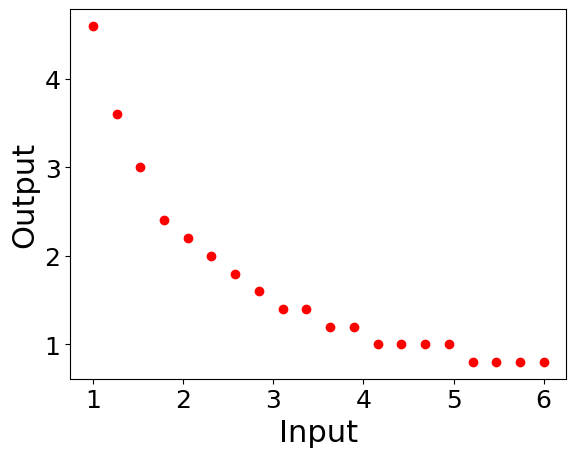

In [ ]:
input_x = np.linspace(1.0, 6.0, num=20)
output_x = np.zeros(20)
for i in range(20):
  output_x[i] = TTFS_Phase_Encoder(np.array([input_x[i]]))
plt.plot(input_x, output_x, 'ro')
plt.xlabel('Input', fontsize = 22)
plt.ylabel('Output', fontsize = 22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

In [ ]:
TTFS_Phase_SpikesList = np.zeros(256)
for i in range(256):
  TTFS_Phase_SpikesList[i] = TTFS_Phase_Encoder(np.array([i]))
print(TTFS_Phase_SpikesList)

[2.902e+02 4.600e+00 2.200e+00 1.400e+00 1.200e+00 1.000e+00 8.000e-01
 6.000e-01 6.000e-01 6.000e-01 6.000e-01 4.000e-01 4.000e-01 4.000e-01
 4.000e-01 4.000e-01 4.000e-01 4.000e-01 4.000e-01 4.000e-01 4.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01
 2.000

/tmp/ipython-input-711865558.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  TTFS_Phase_SpikesList[i] = TTFS_Phase_Encoder(np.array([i]))


It works well. Move to ISI_Phase Encoder.

In [ ]:
def ISI_Phase_Encoder(input, SMO_freq = 5000, TMAX = 295):
  SMO_interval = 1000 / SMO_freq
  SMO_max = np.arange(0, TMAX - 0.1, SMO_interval)
  TT = ISI_Encoder(input)
  for i in range(TT.shape[0]):
    for k in range(SMO_max.shape[0]):
      if SMO_max[k] >= TT[i]:
        TT[i] = SMO_max[k]
        break
  return TT

Test the ISI_Phase Encoder with simple input.

In [ ]:
ISI_PhaseTestResult = ISI_Phase_Encoder(3)
ISI_PhaseTestResult

/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


array([1.4, 1.8, 2.2])

Visualize the ISI-Phase Encoder.

/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


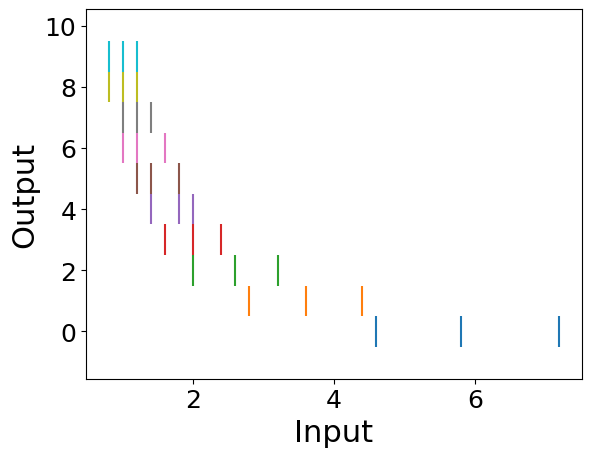

In [ ]:
input_x = np.linspace(1.0, 6.0, num=10)
ISI_Phase_spike_plot = np.zeros((10, 3))
for i in range(10):
  ISI_Phase_spike_plot[i] = ISI_Phase_Encoder(input_x[i])
#print(ISI_Phase_spike_plot)
plt.eventplot(ISI_Phase_spike_plot, colors=['C{}'.format(i) for i in range(ISI_Phase_spike_plot.shape[0])])
plt.xlabel('Input', fontsize = 22)
plt.ylabel('Output', fontsize = 22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

In [ ]:
ISI_Phase_SpikesList = np.zeros((256, 3))
for i in range(256):
  ISI_Phase_SpikesList[i] = ISI_Phase_Encoder(i)
print(ISI_Phase_SpikesList)

[[2.902e+02 2.902e+02 2.902e+02]
 [4.600e+00 5.800e+00 7.200e+00]
 [2.200e+00 2.800e+00 3.400e+00]
 [1.400e+00 1.800e+00 2.200e+00]
 [1.200e+00 1.400e+00 1.600e+00]
 [1.000e+00 1.200e+00 1.400e+00]
 [8.000e-01 1.000e+00 1.200e+00]
 [6.000e-01 8.000e-01 1.000e+00]
 [6.000e-01 8.000e-01 8.000e-01]
 [6.000e-01 6.000e-01 8.000e-01]
 [6.000e-01 6.000e-01 8.000e-01]
 [4.000e-01 6.000e-01 6.000e-01]
 [4.000e-01 6.000e-01 6.000e-01]
 [4.000e-01 4.000e-01 6.000e-01]
 [4.000e-01 4.000e-01 6.000e-01]
 [4.000e-01 4.000e-01 6.000e-01]
 [4.000e-01 4.000e-01 4.000e-01]
 [4.000e-01 4.000e-01 4.000e-01]
 [4.000e-01 4.000e-01 4.000e-01]
 [4.000e-01 4.000e-01 4.000e-01]
 [4.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 4.000e-01 4.000e-01]
 [2.000e-01 2.000e-01 4.000e-01]
 [2.000e-01 2.000e-01 4.000e-01]
 [2.000e-01 2.000e-01 4.000e-01]
 [2.000e-01 2.000e-01 4.000e-01]
 [2.000e-0

/tmp/ipython-input-2974281879.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[j] = TTFS_Encoder(np.array([input]), thr = 0.2 + 0.05 * j)


Load the datasets

In [ ]:
#!!!Run all code above this block
#!!!Run this block

#Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train)
print(y_train)
print(x_test)
print(y_test)
print(x_train.shape)
print(x_train.max(), x_train.min())
print(len(x_train[x_train == 3]))

#Load the spectrum sensing dataset
'''from google.colab import drive
drive.mount('/content/gdrive/')
dataset_path = '/content/gdrive/My Drive/NN/dataset_-15db_Ant6_seed1338.mat'
x_train, y_train, x_test, y_test = GetDataset(dataset_path)
print(x_train, y_train.shape, x_test.shape, y_test.shape)
print(x_train.max(), x_test.max())'''

#Load the CIFAR-10 dataset
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Load the symbol detection dataset
'''
from google.colab import drive
drive.mount('/content/gdrive/')
dataset1_path = '/content/gdrive/My Drive/NN/train_input_mx+1_mx-1_0_5db.npy'
x = np.load(dataset1_path)
print(x.shape)
dataset2_path = '/content/gdrive/My Drive/NN/train_input_y_0_5db.npy'
y = np.load(dataset2_path)
#print(y.shape)
x_train = np.concatenate((x, y), axis =1)
#print(x_train)
#x_train = x_train_1[ :1494]
#x_test = x_train_1[1494:]
#print(x_train.shape)
#print(x_test.shape)
dataset3_path = '/content/gdrive/My Drive/NN/train_label_0_5db.npy'
y_train = np.load(dataset3_path)
#y_train = l[ :1494]
#y_test = l[1494: ]
#print(y_train.shape)
#print(y_test.shape)
channel = 1 #comparison channel
dataset4_path = '/content/gdrive/My Drive/NN/test_input_mx+1_mx-1_0_5db.npy'
x = np.load(dataset4_path)
print(x.shape)
dataset5_path = '/content/gdrive/My Drive/NN/test_input_y_0_5db.npy'
y = np.load(dataset5_path)
print(y.shape)
x_test = np.concatenate((x[channel], y[channel]), axis =1)
print(x_test.shape)
dataset6_path = '/content/gdrive/My Drive/NN/test_label_0_5db.npy'
y_test = np.load(dataset6_path)
print(y_test.shape)
x_test_total = np.concatenate((x, y), axis =2)
print(x_test_total.shape)
'''

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[5 0 4 ... 5 6 8]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\ndataset1_path = '/content/gdrive/My Drive/NN/train_input_mx+1_mx-1_0_5db.npy'\nx = np.load(dataset1_path)\nprint(x.shape)\ndataset2_path = '/content/gdrive/My Drive/NN/train_input_y_0_5db.npy'\ny = np.load(dataset2_path)\n#print(y.shape)\nx_train = np.concatenate((x, y), axis =1)\n#print(x_train)\n#x_train = x_train_1[ :1494]\n#x_test = x_train_1[1494:]\n#print(x_train.shape)\n#print(x_test.shape)\ndataset3_path = '/content/gdrive/My Drive/NN/train_label_0_5db.npy'\ny_train = np.load(dataset3_path)\n#y_train = l[ :1494]\n#y_test = l[1494: ]\n#print(y_train.shape)\n#print(y_test.shape)\nchannel = 1 #comparison channel\ndataset4_path = '/content/gdrive/My Drive/NN/test_input_mx+1_mx-1_0_5db.npy'\nx = np.load(dataset4_path)\nprint(x.shape)\ndataset5_path = '/content/gdrive/My Drive/NN/test_input_y_0_5db.npy'\ny = np.load(dataset5_path)\nprint(y.shape)\nx_test = np.concatenate((x[channel], y[channel]), axis =1)\nprint(x_te

Visualize the dataset case.

9


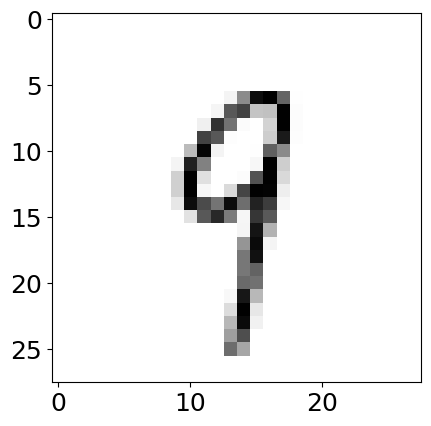

In [ ]:
image_index = 900
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap = 'Greys')
#print(x_train[image_index])

In [ ]:
x_train.shape

In [ ]:
#!!!Skip this block
print(x_train)
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
print(x_train)
image_index = 900
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap = 'Greys')

In [ ]:
x_train.shape

In [ ]:
#!!!Run this block, then run one of the below encoding schemes

#change them to a 1D array
num_pixel = 784
x_train = x_train.reshape(x_train.shape[0], num_pixel) #flattening 60000 by 784
x_test = x_test.reshape(x_test.shape[0], num_pixel)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(x_train)
# #print(x_train[900,])

(60000, 784)
(10000, 784)
(60000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
#Rate
T0 = time.time()
x_train = feature_normalize(x_train) #Not *9 b/c enough detail (784>3) + will be more computationally expensive
x_test = feature_normalize(x_test)
T1 = time.time()
Encoding_T = T1 - T0

num_of_classes = 10
from tensorflow.keras import initializers
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = 784, activation = 'relu'))
  #model.add(Dense(128, input_dim = 784, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))

In [ ]:
#Rate Encoding with limited number of spikes (fire this block + block below)
#Spike num = array element value

T0 = time.time()

#limit spike count to 3
x_train = np.rint((x_train / 255) * 3).astype(int)
x_test = np.rint((x_test / 255) * 3).astype(int) #Rint >.5 go to 1; <.5 go to 0.
print(x_train[x_train>2])

x_train = feature_normalize(x_train) #Normalizing to between 0 and 1
x_test = feature_normalize(x_test)
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
T1 = time.time()
Encoding_T = T1 - T0

num_of_classes = 10
from tensorflow.keras import initializers

[3 3 3 ... 3 3 3]


In [ ]:
#Rate encoding limited num neural network model definition
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = 784, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(128, activation = 'relu'))
  #model.add(Dense(128, input_dim = 784, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004), #ADAM optimizer and learning rate of 0.02
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))

-2.387206079071561e-18 0.9999999999999989


In [ ]:
#TTFS
T0 = time.time()
x_train = TTFS_Encoder(x_train) #Removed, so ignore: +10 means adjusting x_train values to be within a desired time window (fix negative/close to zero values that do not make sense)
print(x_train)
x_test = TTFS_Encoder(x_test)
#print(x_train[900,])

#x_train = feature_normalize(x_train) #don't feature normalize because then it will become default value 290.2 (via the formula with tau and log in TTFS encoder def)
#x_test = feature_normalize(x_test)  #don't feature normalize because then it will become default value 290.2 (via the formula with tau and log in TTFS encoder def)
T1 = time.time()
Encoding_T = T1 - T0

num_of_classes = 10
from tensorflow.keras import initializers
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = 784, activation = 'relu'))
  #model.add(Dense(128, input_dim = 784, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))

[[290.2 290.2 290.2 ... 290.2 290.2 290.2]
 [290.2 290.2 290.2 ... 290.2 290.2 290.2]
 [290.2 290.2 290.2 ... 290.2 290.2 290.2]
 ...
 [290.2 290.2 290.2 ... 290.2 290.2 290.2]
 [290.2 290.2 290.2 ... 290.2 290.2 290.2]
 [290.2 290.2 290.2 ... 290.2 290.2 290.2]]
234.72892529805839 114.08807628765517


In [ ]:
#TTFS-phase

print(TTFS_Phase_SpikesList)
print(x_train)
#print(x_train_temp)

T0 = time.time()

#Original code
"""for i in range(x_train.shape[0]):
  #print(x_train[i])
  x_train[i] = TTFS_Phase_Encoder(np.array([x_train[i]])) #Removed +2


for i in range(x_test.shape[0]):
  x_test[i] = TTFS_Phase_Encoder(np.array([x_test[i]])) #Removed +2"""

#...end of old code

#New code specifically for MNIST dataset

x_train = np.trunc(x_train).astype(int) #Added to match up x_train values to possible values in the x_train pre-processed values retrieval database
x_test = np.trunc(x_test).astype(int)

x_train_temp = np.zeros((60000, 784))
for i in range(60000):
  for j in range(784):
    x_train_temp[i][j] = TTFS_Phase_SpikesList[x_train[i][j]]
print(x_train_temp.shape)

x_test_temp = np.zeros((10000, 784))
for i in range(10000):
  for j in range(784):
    x_test_temp[i][j] = TTFS_Phase_SpikesList[x_test[i][j]]
print(x_test_temp.shape)

x_train = x_train_temp
x_test = x_test_temp

#...end of new code

print(x_train)

x_train = feature_normalize(x_train)
x_test = feature_normalize(x_test)
T1 = time.time()
Encoding_T = T1 - T0

num_of_classes = 10
from tensorflow.keras import initializers
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = 784, activation = 'relu'))
  #model.add(Dense(128, input_dim = 784, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(64, activation='relu',
                  kernel_initializer=initializers.RandomNormal(stddev=.25)))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))

In [ ]:
#ISI (run this + below cell together)

T0 = time.time()

#Start of old code

"""
print(x_train.shape)
x_train_temp = ISI_Encoder(x_train[0]).reshape(1, 3) #What does this do? I thought the shape was 60000 by 28 by 28
print(x_train_temp)
for i in range(1, x_train.shape[0]):
  x_train_temp = np.concatenate((x_train_temp, ISI_Encoder(x_train[i]).reshape(1, 3)), axis = 0)
x_train = x_train_temp
print(x_train.shape)

x_test_temp = ISI_Encoder(x_test[0]).reshape(1, 3)
print(x_test_temp)
for i in range(1, x_test.shape[0]):
  x_test_temp = np.concatenate((x_test_temp, ISI_Encoder(x_test[i]).reshape(1, 3)), axis = 0)
x_test = x_test_temp
print(x_test.shape)

"""

#End of old code
print(x_train.shape)
#Start of MNIST-specific code
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000,784)
x_train_temp = np.zeros((60000, 784, 3))
for i in range(60000):
  for j in range(784):
    x_train_temp[i][j] = ISI_SpikesList[x_train[i][j]]
print(x_train_temp.shape)

x_test_temp = np.zeros((10000, 784, 3))
for i in range(10000):
  for j in range(784):
    x_test_temp[i][j] = ISI_SpikesList[x_test[i][j]]
print(x_test_temp.shape)
x_train = x_train_temp.reshape(60000, 784 * 3)
x_test = x_test_temp.reshape(10000, 784 * 3)

x_train = feature_normalize(x_train)
x_test = feature_normalize(x_test)
T1 = time.time()
#End of MNIST-specific code
Encoding_T = T1 - T0

#print(x_train_temp[59999][209:213])
#print(x_train[59999][627: 639])
#print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

num_spikes = 784 * 3
num_of_classes = 10

In [ ]:
#ISI Encoder model creation
from keras.initializers import HeNormal
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = num_spikes, activation = 'relu'))
  #model.add(Dense(128, input_dim = num_spikes, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))
print(x_train)
print(x_test)

In [ ]:
#ISI-Phase (run this block + the next block)

#Start of original code
'''x_train_temp = ISI_Phase_Encoder(x_train[0]).reshape(1, 3)
print(x_train_temp)
for i in range(1, x_train.shape[0]):
  x_train_temp = np.concatenate((x_train_temp, ISI_Phase_Encoder(x_train[i]).reshape(1, 3)), axis = 0)
x_train = x_train_temp
print(x_train.shape)

x_test_temp = ISI_Phase_Encoder(x_test[0]).reshape(1, 3)
print(x_test_temp)
for i in range(1, x_test.shape[0]):
  x_test_temp = np.concatenate((x_test_temp, ISI_Phase_Encoder(x_test[i]).reshape(1, 3)), axis = 0)
x_test = x_test_temp'''
#End of original code

#Start of MNIST-specific code
x_train_temp = np.zeros((60000, 784, 3))
for i in range(60000):
  for j in range(784):
    x_train_temp[i][j] = ISI_Phase_SpikesList[x_train[i][j]]
print(x_train_temp.shape)
#End of MNIST-specific code

x_test_temp = np.zeros((10000, 784, 3))
for i in range(10000):
  for j in range(784):
    x_test_temp[i][j] = ISI_Phase_SpikesList[x_test[i][j]]
print(x_test_temp.shape)
x_train = x_train_temp.reshape(60000, 784 * 3)
x_test = x_test_temp.reshape(10000, 784 * 3)

T0 = time.time()

print(x_test.shape)

x_train = feature_normalize(x_train)
x_test = feature_normalize(x_test)
T1 = time.time()
Encoding_T = T1 - T0

num_spikes =784 * 3
num_of_classes = 10

In [ ]:
#ISI-Phase encoder neural network definition
from tensorflow.keras import initializers
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim = num_spikes, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(128, activation = 'relu'))
  #model.add(Dense(128, input_dim = num_spikes, activation = 'relu',
  #                kernel_initializer=initializers.RandomNormal(stddev=.15)))
  #model.add(Dense(30, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.004),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

print(np.mean(x_train), np.std(x_train))

In [ ]:
#!!!Run this block of code and all below

model = create_model()
print(model.summary())
y_train_use = utils.to_categorical(y_train, 10)
y_test_use = utils.to_categorical(y_test, 10)
print(y_train_use.shape, y_test_use.shape)
#print(y_train[image_index])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501,770 (5.73 MB)

 Trainable params: 1,501,770 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

None
(60000, 10) (10000, 10)


In [ ]:
T0 = time.time()
history = model.fit(x_train, y_train_use, validation_split=0.1,
         epochs=100, batch_size=128, verbose=1, shuffle=1)
T1 = time.time()
Train_T = T1 - T0

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4776 - loss: 122.1596 - val_accuracy: 0.8977 - val_loss: 0.3426
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.3829 - val_accuracy: 0.9277 - val_loss: 0.2358
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9076 - loss: 0.3022 - val_accuracy: 0.9207 - val_loss: 0.2563
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9181 - loss: 0.2682 - val_accuracy: 0.9305 - val_loss: 0.2318
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9264 - loss: 0.2468 - val_accuracy: 0.9467 - val_loss: 0.1833
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9259 - loss: 0.2426 - val_accuracy: 0.9247 - val_loss: 0.2458
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9271 - loss: 0.2409 - val_accuracy: 0.9462 - val_loss: 0.1864
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9364 - loss: 0.2108 - val_a

In [ ]:
score = model.evaluate(x_test, y_test_use, verbose=1)

print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])
print('Training Time:', Train_T)
print('Running Time:', Encoding_T + Train_T)

#predicted_prob = np.zeros((3,3000,2))
#for n in range(x_test_total.shape[0]):
#  predicted_prob[n] = model.predict(x_test_total[n])
#print(predicted_prob.shape)
#print(predicted_prob[0])
#print(predicted_prob[1])


In [ ]:
print(x_train)
print(x_train.shape)
print(x_test)
print(x_train.shape)

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10) )
train_x = range(1, len(history.history["accuracy"])+1)
train_y = history.history["accuracy"]
train_loss = history.history["loss"]
ax[0,0].plot(train_x, train_y)
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Training Accuracy")
ax[0,0].set_xticks(range(1, 16))
ax[0,0].tick_params(axis = "both", labelsize = 12)
ax[0,0].set_yticks(np.linspace(start = min(train_y), stop = max(train_y), num = 10))

val_x = range(1, len(history.history["val_accuracy"])+1)
val_y = history.history["val_accuracy"]
ax[0,1].plot(val_x , val_y)
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Validation Accuracy")
ax[0,1].set_xticks(range(1, 16))
ax[0,1].set_yticks(np.linspace(start = min(val_y), stop = max(val_y), num = 10))
ax[0,1].tick_params(axis = "both", labelsize = 12)

train_loss = history.history["loss"]
ax[1,0].plot(train_x, train_loss)
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Training Loss")
ax[1,0].set_xticks(range(1, 16))
ax[1,0].tick_params(axis = "both", labelsize = 12)
ax[1,0].set_yticks(np.linspace(start = min(train_loss), stop = max(train_loss), num = 10))

val_loss = history.history["val_loss"]
ax[1,1].plot(train_x, val_loss)
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Validation Loss")
ax[1,1].set_xticks(range(1, 16))
ax[1,1].tick_params(axis = "both", labelsize = 12)
ax[1,1].set_yticks(np.linspace(start = min(val_loss), stop = max(val_loss), num = 10))

plt.show()